# Blog analysis using tfidf metrics unigrams

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import logging
import numpy as np
import pandas as pd

from tqdm import tqdm
from bs4 import BeautifulSoup
from utils import *

import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

tqdm.pandas(desc="Preprocess dataset")
%matplotlib inline

In [3]:
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s", level=logging.INFO)
logger = logging.getLogger()

# Load Dataset

In [4]:
blogs_df = pd.read_csv("data/blogs_data.csv")

In [5]:
blogs_df.head() # This data is already preprocess and normalize in English

,id,title,content,slug,data,lang,normalize_data
0,5173,Why Scalability Matters for Your App,Building an app is an extensive process. From ...,why-scalability-matters-for-your-app,Why Scalability Matters for Your App Building ...,en,Why Scalability Matters for Your App Building ...
1,5174,Is a Scrum Agile Development Process Right for...,A Brief History of Scrum Agile Development: \n...,is-a-scrum-agile-development-process-right-for...,Is a Scrum Agile Development Process Right for...,en,Is a Scrum Agile Development Process Right for...
2,5175,How to Make Your App Irresistible Through User...,Guessing is a part of life—and it’s necessary....,how-to-make-your-app-irresistible-through-user...,How to Make Your App Irresistible Through User...,en,How to Make Your App Irresistible Through User...
3,5176,5 Product Manager MUSTS for Creating a Success...,Product management is a tough job. You must tr...,5-product-manager-musts-for-creating-a-success...,5 Product Manager MUSTS for Creating a Success...,en,5 Product Manager MUSTS for Creating a Success...
4,5177,7 Key Questions to Ask Your Prospective App De...,From the moment you decide to move forward wit...,7-key-questions-to-ask-prospective-app-develop...,7 Key Questions to Ask Your Prospective App De...,en,7 Key Questions to Ask Your Prospective App De...


In [6]:
print(blogs_df["normalize_data"][0])

Why Scalability Matters for Your App Building an app is an extensive process. From a fresh idea to a marketable product, the journey is filled with ups and downs. So, when you (hopefully) build that successful app, the last thing you want is for it to hit a dead end.
However, that’s, unfortunately, the way it usually goes. You might think that accelerated growth is totally positive, as users are downloading your app at a record rate. But, an app that isn’t designed and developed to seamlessly handle this explosive growth will eventually end up being a failure.
Consider this: is your app, as it stands today, able to scale up to exponential growth? If you have any doubts, you need to seriously consider this scalability issue.

What is app scalability?
Scalability is the ability of your app to handle a growing number of customers, clients and/or users. It also pertains to the ability of your current or future developer to maintain the app. Consider the possibility that your app isn’t curr

# Preprocess data for training

In [7]:
regex = get_regex_expression()
regex

'(https?:\\/\\/.*[\\r\\n])|(\\#[^\\s]*)|(\\@[^\\s]*)|(author)|(\\S*@\\S+)|([^a-zA-Z0-9À-ÿ\\u00f1\\u00d1\\s])'

In [8]:
example = preprocess_data(blogs_df["normalize_data"][0], regex, 
                          removing_stops=True, lemmatize=True)
print(example)

['scalability', 'matter', 'app', 'build', 'app', 'extensive', 'process', 'fresh', 'idea', 'marketable', 'product', 'journey', 'fill', 'up', 'down', 'hopefully', 'build', 'successful', 'app', 'thing', 'want', 'hit', 'dead', 'end', 'unfortunately', 'way', 'usually', 'go', 'think', 'accelerated', 'growth', 'totally', 'positive', 'user', 'download', 'app', 'record', 'rate', 'app', 'isn', 'design', 'develop', 'seamlessly', 'handle', 'explosive', 'growth', 'eventually', 'end', 'failure', 'consider', 'app', 'stand', 'today', 'able', 'scale', 'exponential', 'growth', 'doubt', 'need', 'seriously', 'consider', 'scalability', 'issue', 'app', 'scalability', 'scalability', 'ability', 'app', 'handle', 'grow', 'number', 'customer', 'client', 'user', 'pertain', 'ability', 'current', 'future', 'developer', 'maintain', 'app', 'consider', 'possibility', 'app', 'isn', 'currently', 'scalable', 'prepared', 'scramble', 'add', 'necessary', 'additional', 'feature', 'flexible', 'coding', 'keep', 'app', 'run', '

In [9]:
# Train data doing lemmatization and removing stopswords
train_data = [preprocess_data(normalize_data, regex, True, True) 
                for normalize_data in tqdm(blogs_df["normalize_data"].values)]

100%|██████████| 458/458 [00:51<00:00,  8.95it/s]


In [10]:
print(train_data[0])

['scalability', 'matter', 'app', 'build', 'app', 'extensive', 'process', 'fresh', 'idea', 'marketable', 'product', 'journey', 'fill', 'up', 'down', 'hopefully', 'build', 'successful', 'app', 'thing', 'want', 'hit', 'dead', 'end', 'unfortunately', 'way', 'usually', 'go', 'think', 'accelerated', 'growth', 'totally', 'positive', 'user', 'download', 'app', 'record', 'rate', 'app', 'isn', 'design', 'develop', 'seamlessly', 'handle', 'explosive', 'growth', 'eventually', 'end', 'failure', 'consider', 'app', 'stand', 'today', 'able', 'scale', 'exponential', 'growth', 'doubt', 'need', 'seriously', 'consider', 'scalability', 'issue', 'app', 'scalability', 'scalability', 'ability', 'app', 'handle', 'grow', 'number', 'customer', 'client', 'user', 'pertain', 'ability', 'current', 'future', 'developer', 'maintain', 'app', 'consider', 'possibility', 'app', 'isn', 'currently', 'scalable', 'prepared', 'scramble', 'add', 'necessary', 'additional', 'feature', 'flexible', 'coding', 'keep', 'app', 'run', '

# TFIDF analysis

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [12]:
train_data = [' '.join(text_vector) for text_vector in tqdm(train_data)]

100%|██████████| 458/458 [00:00<00:00, 102023.01it/s]


In [13]:
tfidf = TfidfVectorizer(tokenizer=lambda text: text.split())

## Training

In [14]:
tfidf.fit(train_data)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function <lambda> at 0x7f888eee2b00>, use_idf=True,
                vocabulary=None)

In [15]:
TFIDF_MATRIX = tfidf.transform(train_data)

In [16]:
TFIDF_MATRIX.shape

(458, 10286)

## Get vocabulary

In [17]:
vocab = np.array(tfidf.get_feature_names())

In [18]:
vocab.shape

(10286,)

In [19]:
vocab[100:120]

array(['accommodate', 'accommodation', 'accompany', 'accomplish',
       'accomplishment', 'accord', 'accordingly', 'account',
       'accountability', 'accountable', 'accountant', 'accounting',
       'accredit', 'accredited', 'accumulate', 'accumulating', 'accuracy',
       'accurate', 'accurately', 'accuse'], dtype='<U21')

## Get topics distribution using NMF

In [20]:
from sklearn import decomposition

In [21]:
m, n = TFIDF_MATRIX.shape
d = 20 # Number of topics, this is just a gess

### NMF

In [22]:
NMF_model = decomposition.NMF(n_components=d)

In [23]:
NMF_model.fit(TFIDF_MATRIX)
U = NMF_model.transform(TFIDF_MATRIX)
V = NMF_model.components_

In [24]:
U.shape, V.shape

((458, 20), (20, 10286))

The idea of non negatice matrix factorization is to take the tfidf matrix with dimensions $458, 10286$
where the rows are the blogs and the columns are the words, and factor that matrix into two:

$$T = U \times V$$ where $T \in R^{b,w}$, $U \in R^{b, t}$ and $V \in R^{t, w}$
where $b=blogs$, $t=topics$, $w=words$

In [25]:
show_topics(V, vocab)

['app user feature need download idea launch good',
 'product mvp idea market feature problem user build',
 'customer marketing datum strategy content value churn analytic',
 'patient medical healthcare health medtech doctor wearable care',
 'retail store retailer shopping shopper consumer online mobile',
 'fintech financial blockchain banking bank regulation service transaction',
 'iot device technology smart control network system sector',
 'ai human ml machine intelligence robot artificial hitech',
 'saas customer software vertical solution churn micro company',
 'website design user site web content ux responsive',
 'shopify plus magento business platform ecommerce online alternative',
 'android ios app platform development developer user apple',
 'development partner team app project devops outsource agency',
 'ar vr reality virtual augment technology camera experience',
 'transformation digital company innovation culture employee team change',
 'koombea clutch client jonathan tar

### Plots tfidf weights

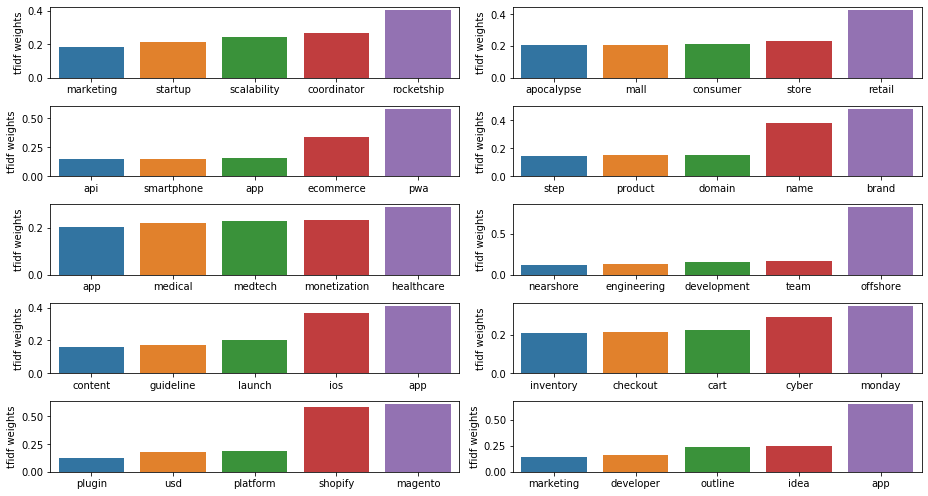

In [26]:
visualize_tfidf_weights(TFIDF_MATRIX.toarray(), vocab, top_n=5, total=10, width=13, 
                        height=7, div=2)

### Plot tfidf weights in each topic

Using the matrix V we can show the important of each word in each topic

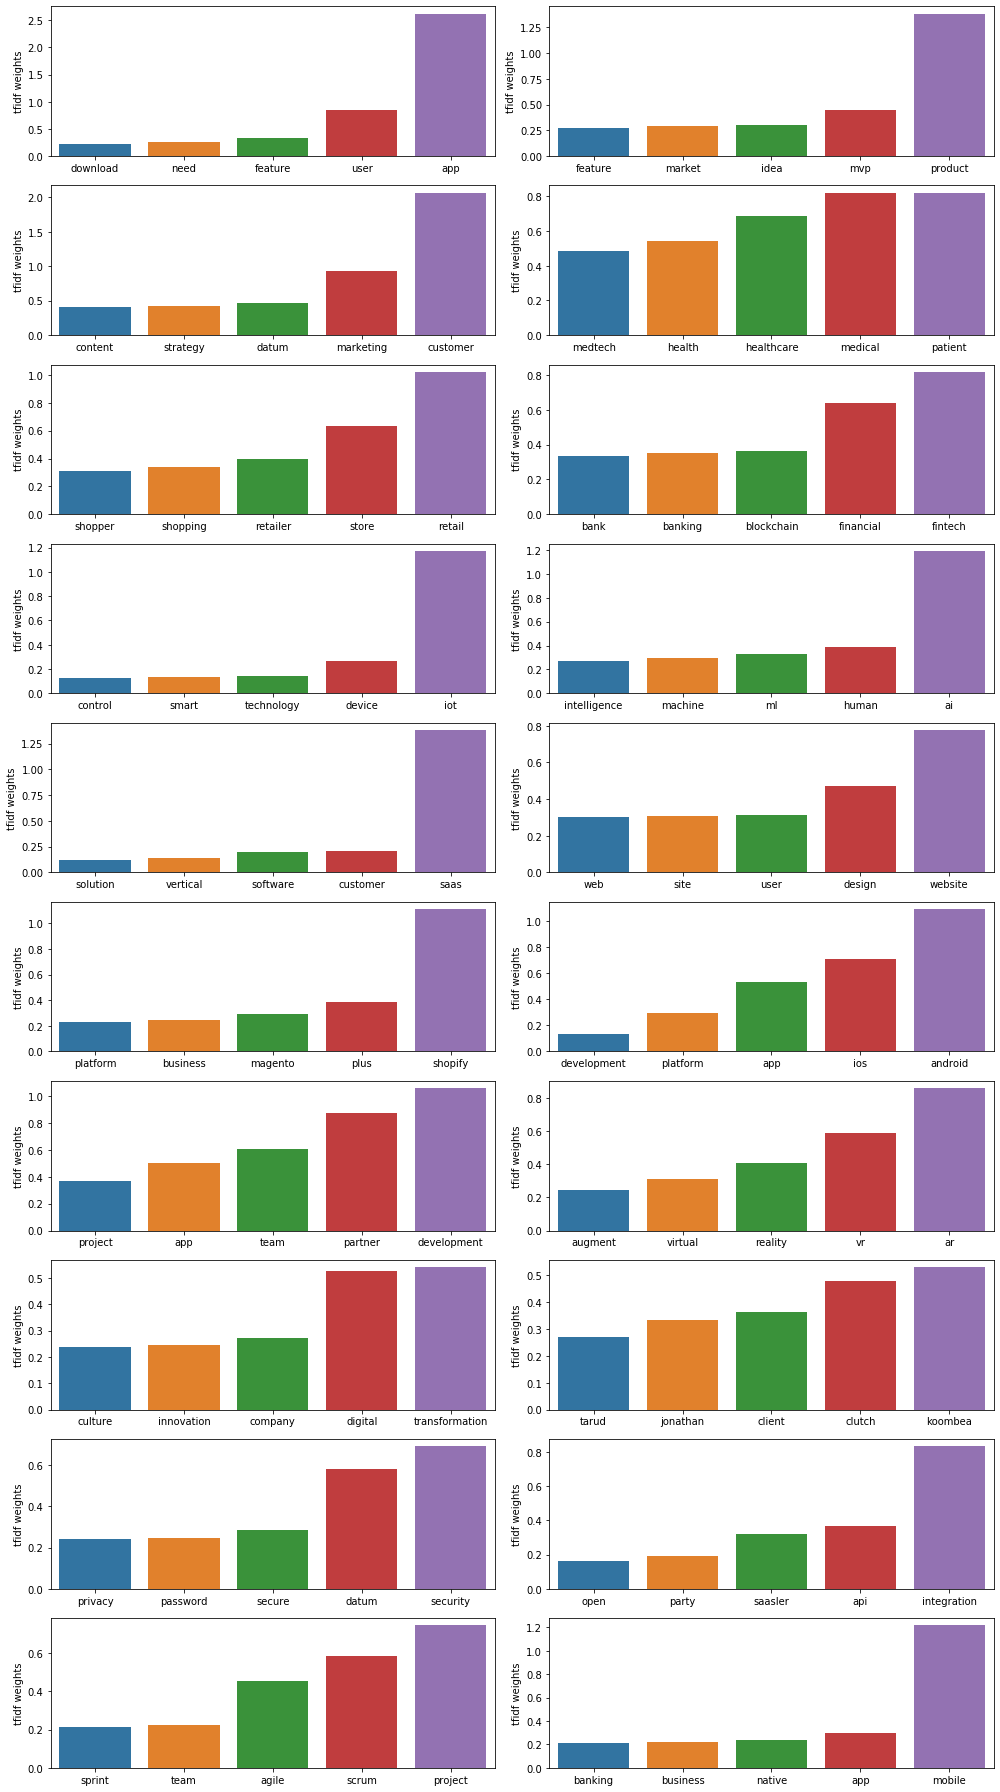

In [27]:
visualize_tfidf_topics_weights(V, vocab, top_n=5, width=14, height=25, 
                               div=2)

### Use dimensionality reduction techniques to plot on $R^{2}$

First we are going to use truncatedSVD on tfidfmatrix to reduce the dimension to 50, and then tsne to map the matrix to $R^{2}$ and then see the blogs on a two dimensional space

#### Truncated svd to reduce down to 50 dimension

In [28]:
truncated_svd = decomposition.TruncatedSVD(n_components=50)

In [29]:
truncated_svd.fit(TFIDF_MATRIX)

TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
             random_state=None, tol=0.0)

In [30]:
X_truncated = truncated_svd.transform(TFIDF_MATRIX)

#### Use of tsne to project to 2 dimension

In [31]:
from sklearn.manifold import TSNE

In [32]:
tsne_mapping = TSNE()

In [33]:
X_ = tsne_mapping.fit_transform(X_truncated)

#### Visualize data with clusters

In [34]:
from sklearn.cluster import KMeans

In [35]:
kmeans = KMeans(n_clusters=30)

In [36]:
kmeans.fit(X_)
clusters = kmeans.predict(X_)

<IPython.core.display.Javascript object>


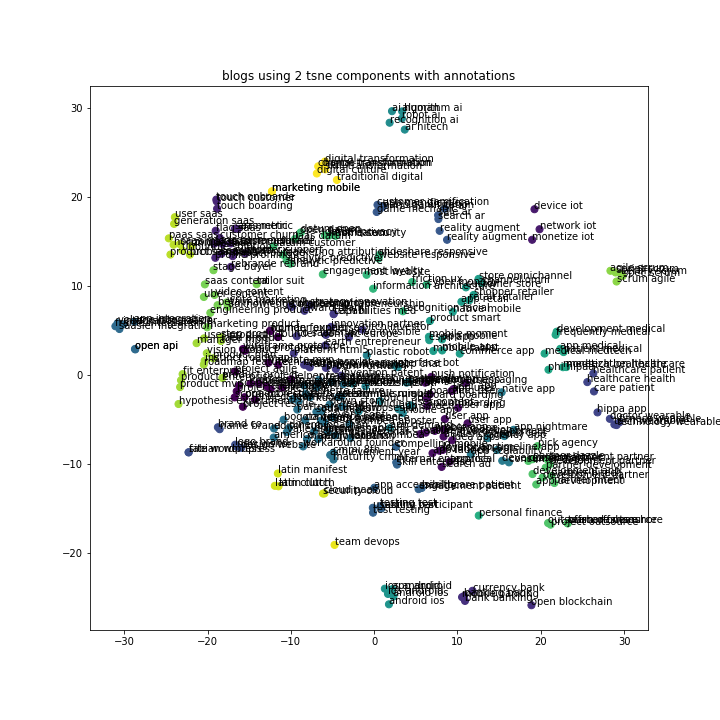

In [38]:
%matplotlib notebook
plots_blogs_embedding(TFIDF_MATRIX, X_, vocab, clusters, width=10, height=10)

On the previous plot there are some define cluster for exampel the yellow ones are the blogs related to medical topics

In [40]:
import pickle
pickle.dump(TFIDF_MATRIX, open("model/tfidf_unigrams.pickle", "wb"))
pickle.dump(vocab, open("model/vocab_unigrams.pickle", "wb"))